# Mini-Project #4 (Part A)

Student Name: **Subhadyuti Sahoo**
<br>
Course: **Adv Topics in Machine Learning**

### Importing Necessary Libraries, Modules and Classes

In [1]:
import os
import time
import datetime
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import statistics
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU, PReLU, Dense, LSTM 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import losses
import warnings
from numpy.random import seed
tf.random.set_seed(1234)
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Importing the Dataset

In [2]:
# Forming the pandas dataframe
# entireDataSet = pd.read_csv('/content/drive/My Drive/AdvTopicsInML/NVDA.csv')   # for Google Colab
entireDataSet = pd.read_csv('NVDA.csv')   # for Jupyter Notebook

# Displaying the pandas dataFrame
display(entireDataSet)  

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,1.750000,1.953125,1.552083,1.640625,1.508412,67867200
1,1999-01-25,1.770833,1.833333,1.640625,1.812500,1.666436,12762000
2,1999-01-26,1.833333,1.869792,1.645833,1.671875,1.537143,8580000
3,1999-01-27,1.677083,1.718750,1.583333,1.666667,1.532354,6109200
4,1999-01-28,1.666667,1.677083,1.651042,1.661458,1.527566,5688000
...,...,...,...,...,...,...,...
5561,2021-03-01,555.000000,557.000000,542.130005,553.669983,553.669983,8802500
5562,2021-03-02,556.000000,556.820007,535.840027,536.250000,536.250000,6585500
5563,2021-03-03,537.049988,538.059998,511.950012,512.190002,512.190002,9408000
5564,2021-03-04,512.030029,519.000000,483.350006,494.809998,494.809998,14292400


<a id='Description'></a>
<div class=" alert alert-warning">
    <b>Description.</b>
 
Same as Mini-project #3, this project will use the historic adjusted closing price data of NVDA as the training/test data and build an artificial neural network (ANN) to predict the adjusted closing price in the future. We will only use the adjusted closing price. We will $60:20:20$ split the data for training, validation and test, reserving the most recent $20\%$ data for test, as though we had traveled back in time to September $30, 2016$. We will try to see if different activation function or LSTM can lead to better prediction with higher
accuracy.
    
</div>

### Extracting The Working Dataset

In [3]:
dSet = pd.DataFrame(entireDataSet['Adj Close'], columns=['Adj Close'])   # Working with only the Adjusted Closing Price

### Checking for Missing Values (if any)

In [4]:
# Checking if there are missing values in the workign dataset
result = (dSet.isna().values.any()) or (dSet.isnull().values.any())
if (result == True):
    n_missing_values = dSet.isna().sum().sum() + dSet.isnull().sum().sum()

# Displaying if there are any missing values in dataFrame
print('--- Checking for Missing Values ---')
print('Q. Are there any missing values in the dataset?')   
if (result == True):
    print('A. Yes')
    print('Q. How many?')
    print('A. ', n_missing_values)
else:
    print('A. No') 
print('-----------------------------------')
print('\n')

--- Checking for Missing Values ---
Q. Are there any missing values in the dataset?
A. No
-----------------------------------




### Splitting the Working Dataset

In [5]:
# Splitting the data after September 30, 2016
dates = entireDataSet['Date'].to_numpy()
trainval_indices = np.where(dates < '2016-10-01')
trainval_index_start = trainval_indices[0][0]
trainval_index_end = trainval_indices[0][-1]

# Converting the working dataset to a numpy array 
dSet = dSet.values
dSet = dSet.astype('float32')  # Converting to Tensor Form

# Splitting the working dataset into train, val and test datasets
n = (0.6 * len(dSet)) / trainval_index_end
trainDataSet = dSet[:int(n*trainval_index_end)]
valDataSet = dSet[int(n*trainval_index_end):trainval_index_end+1]
testDataSet = dSet[trainval_index_end+1:]
tempTestDates = entireDataSet['Date'][trainval_index_end+1:]

<a id='Student Task'></a>
<div class=" alert alert-warning">
    <b>Student Task.</b>
 
Use the best model you have from Mini-project #3, and play with different activation functions in different layers. You may use different activations in different layers. 

</div>

<a id='QuestionA'></a>
<div class=" alert alert-warning">
    <b>Question.</b>
 
Provide your model design description.

</div>

<a id='AnswerQA'></a>
<div class=" alert alert-info">
    <b>Answer.</b>

$\textbf{Model Design Description}$: 

- The activation functions for the hidden layers have been carefully chosen to be either of the Linear Unit family or close to Linear Unit family ($\texttt{softplus}$), since this is a regression problem
    
- $\texttt{No}$ activation function has been chosen for the output layer as activation functions in the output layers for regression problems can cause issues by abruptly shutting down the gate and thus, can produce zero as the output all the time (since the model is learning nothing at all)
    
- The model with the lowest MSE score for the validation dataset has been ultimately chosen to be the best model
    
</div>

### User-Defined Function to Form Training, Validation and Test Datasets Depending Upon Prior Days

In [6]:
def get_refurbished_datasets(dataset, prior_days):
    """
    Returns the reconfigured datasets for 'n' prior days
  
    Args: 
      dataset (vector, shape = [n, 1]): the column of interest from the entire, bigger dataset
      prior_days (int): the number of prior days for which the column of interest needs to be reconfigured
    """
    
    # Forming empty lists to store data
    X_, y_ = [], []
    
    # Forming the reconfigured datasets for 'n' prior days
    for i in range(len(dataset)-prior_days):
        a = dataset[i:(i + prior_days), 0]
        X_.append(a)
        y_.append(dataset[i + prior_days, 0])
        
    # Returning the reconfigured datasets
    return np.array(X_), np.array(y_)

### Forming the Working Datasets for Training, Validation and Test for 10 Prior Days

In [7]:
# Mentioning the prior days
prior_days = 10

# Forming the final training dataset
X_train, y_train = get_refurbished_datasets(dataset=trainDataSet, prior_days=prior_days)

# Forming the final validation dataset
X_val, y_val = get_refurbished_datasets(dataset=valDataSet, prior_days=prior_days)

# Forming the final test dataset
X_test, y_test = get_refurbished_datasets(dataset=testDataSet, prior_days=prior_days)

# Printing out the shapes of each dataset
print('--- Shapes of Each Dataset (' + str(prior_days) + ' Prior Days) ---')
print(f'Training Features Dataset Shape: {X_train.shape}')
print(f'Training Labels Dataset Shape: {y_train.shape}')
print(f'Validation Features Dataset Shape: {X_val.shape}')
print(f'Validation Labels Dataset Shape: {y_val.shape}')
print(f'Test Features Dataset Shape: {X_test.shape}')
print(f'Test Labels Dataset Shape: {y_test.shape}')
print('----------------------------------------------')

--- Shapes of Each Dataset (10 Prior Days) ---
Training Features Dataset Shape: (3329, 10)
Training Labels Dataset Shape: (3329,)
Validation Features Dataset Shape: (1104, 10)
Validation Labels Dataset Shape: (1104,)
Test Features Dataset Shape: (1103, 10)
Test Labels Dataset Shape: (1103,)
----------------------------------------------


### Creating A User-Defined Function to Build Customized ANN Models

In [8]:
def build_model(init_empty_model, trainFeatures, n_neurons, act_func):
    """
    Returns the customized model 
  
    Args:
      init_empty_model (keras sequential model): the skeletion of the final model returned 
      trainFeatures (array, shape = [m, n]): the training dataset features
      n_neurons (int): the number of neurons each of the hidden layers are going to contain
      act_func: the activation function for the hidden layers
    """

    # Calcuate the input dimensions to be used for building the model
    inputDim = trainFeatures.shape[1]

    # Putting the skeleton model into the variable which is going to get filled up soon
    filled_model = init_empty_model

    # Building the final model which is gonna be returned 
    filled_model.add(Dense(units = n_neurons,
                             
                           # Activation function for hidden layer
                           activation = act_func,

                           input_dim = inputDim
                          )
                    )
  
    # Adding the final output layer to the final model
    filled_model.add(Dense(units=1))

    # Returning the final model
    return filled_model

### Creating A User-Defined Function In Order To Compile and Train Different ANN Models 

In [9]:
def compile_and_fit(model, trainFeatures, trainLabels, valFeatures,
                    valLabels, batchSize, n_epochs, verBose):
    """
    Returns a compiled model
  
    Args:
      model (keras sequential model): the filled model
      trainFeatures (array, shape = [m,n]): the training dataset features
      trainLabels (vector, shape = [m,1]): the training dataset labels
      valFeatures (array, shape = [p, n]): the validation dataset features
      valLabels (vector, shape = [p,1]): the validation dataset labels
      batchSize (int): the max no. of batches to be used for compiling the model
      n_epochs (int): the max no. iterations for simulating the model
    """

    # Compiling the model
    model.compile(# Objective (Loss) Function
                  loss = 'mean_squared_error',  # meanSquaredError

                  # Optimizer
                  optimizer = 'adam'
                 )
  
    # Training the model
    history = model.fit(x = trainFeatures,
                        y = trainLabels,
                        batch_size = batchSize, 
                        epochs = n_epochs,
                        validation_data = (valFeatures, valLabels),
                        verbose = verBose)
  
    # Returning the compiled model
    return history 

### Creating A User-Defined Function for Estimating Mean Squared Errors

In [10]:
def get_mse(model, realFeatures, realLabels):
    """
    Returns the mean squared error values
    
    Args:
      model: the ANN model
      realFeatures: the actual features of the three different datasets
      realLabels: the actual labels of the three different datasets
    """
    
    # Predicting the values
    predLabels = model.predict(realFeatures)
    
    # Calculating the mean squared error
    meanSquaredError = mean_squared_error(realLabels, predLabels)
    
    # Returning mean squared error
    return meanSquaredError

### The Best ANN Model from Mini-Project #3 (1 Hidden Layer with 80 Hidden Neurons, ReLU Activation Function, 10 Prior Days)

In [11]:
# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (ReLU, 10 Prior Days)
model10801relu = Sequential() 
model10801relu = build_model(init_empty_model=model10801relu, trainFeatures=X_train, 
                             n_neurons=80, act_func='relu') 
model10801relu.summary()
#tf.keras.utils.plot_model(model7201,
#                          to_file = 'model7201.png',
#                          show_shapes = True, 
#                          show_layer_names = True
#                         )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                880       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


### Compiling and Training the ANN Model containing 1 Hidden Layer with 80 Hidden Neurons for 10 Prior Days (ReLU Activation Function)

In [12]:
history10801relu = compile_and_fit(model=model10801relu, trainFeatures=X_train, trainLabels=y_train, 
                                   valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

### Computing MSE for Training and Validation Datasets for ANN Model containing 1 Hidden Layer with 80 Hidden Neurons for 10 Prior Days (ReLU Activation Function)

In [13]:
# Calculating MSE for training dataset
trainMSE10801relu = get_mse(model=model10801relu, realFeatures=X_train, realLabels=y_train)

# Calculating MSE for validation dataset
valMSE10801relu = get_mse(model=model10801relu, realFeatures=X_val, realLabels=y_val)

# Print the values
print('--- MSE Values for the ANN Model with 1 Hidden Layer with 80 Hidden Neurons (10 Prior Days, ReLU Activation Function) ---')
print('Train Score: %.2f MSE' % (trainMSE10801relu))
print('Val Score: %.2f MSE' % (valMSE10801relu))
print('-------------------------------------------------------------------------------------------------------------------------')

--- MSE Values for the ANN Model with 1 Hidden Layer with 80 Hidden Neurons (10 Prior Days, ReLU Activation Function) ---
Train Score: 0.40 MSE
Val Score: 0.54 MSE
-------------------------------------------------------------------------------------------------------------------------


### ANN Model with 1 Hidden Layer with 80 Hidden Neurons (Different Activation Functions, 10 Prior Days)

In [14]:
# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (LeakyReLU, 10 Prior Days)
leaky_relu = LeakyReLU(alpha=0.01)
model10801leakyrelu = Sequential() 
model10801leakyrelu = build_model(init_empty_model=model10801leakyrelu, trainFeatures=X_train, 
                                  n_neurons=80, act_func=leaky_relu) 
model10801leakyrelu.summary()

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (Parametric LeakyReLU, 10 Prior Days)
para_leaky_relu = PReLU()
model10801paraleakyrelu = Sequential() 
model10801paraleakyrelu = build_model(init_empty_model=model10801paraleakyrelu, trainFeatures=X_train, 
                                      n_neurons=80, act_func=para_leaky_relu) 
model10801paraleakyrelu.summary()

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (GELU, 10 Prior Days)
model10801gelu = Sequential() 
model10801gelu = build_model(init_empty_model=model10801gelu, trainFeatures=X_train, 
                             n_neurons=80, act_func='gelu') 
model10801gelu.summary()

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (ELU, 10 Prior Days)
model10801elu = Sequential() 
model10801elu = build_model(init_empty_model=model10801elu, trainFeatures=X_train, 
                             n_neurons=80, act_func='elu') 
model10801elu.summary()

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (SELU, 10 Prior Days)
model10801selu = Sequential() 
model10801selu = build_model(init_empty_model=model10801selu, trainFeatures=X_train, 
                             n_neurons=80, act_func='selu') 
model10801selu.summary()

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (Softplus, 10 Prior Days)
model10801softplus = Sequential() 
model10801softplus = build_model(init_empty_model=model10801softplus, trainFeatures=X_train, 
                                 n_neurons=80, act_func='softplus') 
model10801softplus.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 80)                880       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 80)                960       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 81        
Total params: 1,041
Trainable params: 1,041
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
__________

### Compiling and Training the ANN Model containing 1 Hidden Layer with 80 Hidden Neurons for 10 Prior Days (Different Activation Functions)

In [15]:
# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (LeakyReLU, 10 Prior Days)
history10801leakyrelu = compile_and_fit(model=model10801leakyrelu, trainFeatures=X_train, trainLabels=y_train, 
                                        valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (Parametric LeakyReLU, 10 Prior Days)
history10801paraleakyrelu = compile_and_fit(model=model10801paraleakyrelu, trainFeatures=X_train, trainLabels=y_train, 
                                            valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (GELU, 10 Prior Days)
history10801gelu = compile_and_fit(model=model10801gelu, trainFeatures=X_train, trainLabels=y_train, 
                                   valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (ELU, 10 Prior Days)
history10801elu = compile_and_fit(model=model10801elu, trainFeatures=X_train, trainLabels=y_train, 
                                  valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (SELU, 10 Prior Days)
history10801selu = compile_and_fit(model=model10801selu, trainFeatures=X_train, trainLabels=y_train, 
                                   valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (Softplus, 10 Prior Days)
history10801softplus = compile_and_fit(model=model10801softplus, trainFeatures=X_train, trainLabels=y_train, 
                                       valFeatures=X_val, valLabels=y_val, batchSize=32, n_epochs=20, verBose=0)

### Computing MSE for Training and Validation Datasets for ANN Model containing 1 Hidden Layer with 80 Hidden Neurons for 10 Prior Days (Different Activation Functions)

In [16]:
# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (LeakyReLU, 10 Prior Days)
trainMSE10801leakyrelu = get_mse(model=model10801leakyrelu, realFeatures=X_train, realLabels=y_train) # Calculating MSE for training dataset
valMSE10801leakyrelu = get_mse(model=model10801leakyrelu, realFeatures=X_val, realLabels=y_val) # Calculating MSE for validation dataset

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (Parametric LeakyReLU, 10 Prior Days)
trainMSE10801paraleakyrelu = get_mse(model=model10801paraleakyrelu, realFeatures=X_train, realLabels=y_train) # Calculating MSE for training dataset
valMSE10801paraleakyrelu = get_mse(model=model10801paraleakyrelu, realFeatures=X_val, realLabels=y_val) # Calculating MSE for validation dataset

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (GELU, 10 Prior Days)
trainMSE10801gelu = get_mse(model=model10801gelu, realFeatures=X_train, realLabels=y_train) # Calculating MSE for training dataset
valMSE10801gelu = get_mse(model=model10801gelu, realFeatures=X_val, realLabels=y_val) # Calculating MSE for validation dataset

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (ELU, 10 Prior Days)
trainMSE10801elu = get_mse(model=model10801elu, realFeatures=X_train, realLabels=y_train) # Calculating MSE for training dataset
valMSE10801elu = get_mse(model=model10801elu, realFeatures=X_val, realLabels=y_val) # Calculating MSE for validation dataset

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (SELU, 10 Prior Days)
trainMSE10801selu = get_mse(model=model10801selu, realFeatures=X_train, realLabels=y_train) # Calculating MSE for training dataset
valMSE10801selu = get_mse(model=model10801selu, realFeatures=X_val, realLabels=y_val) # Calculating MSE for validation dataset

# ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (Softplus, 10 Prior Days)
trainMSE10801softplus = get_mse(model=model10801softplus, realFeatures=X_train, realLabels=y_train) # Calculating MSE for training dataset
valMSE10801softplus = get_mse(model=model10801softplus, realFeatures=X_val, realLabels=y_val) # Calculating MSE for validation dataset

<a id='QuestionB'></a>
<div class=" alert alert-warning">
    <b>Question.</b>
 
What can you find? Report the best model you can obtain that yields highest accuracy (lowest MSE). Plot the training and validation accuracy vs. training iteration (epochs) for the model. 

</div>

### Bar Plot of Traning and Validation MSE Scores for ANN Models containing 1 Hidden Layer with 80 Neurons (Different Activation Functions, 10 Prior Days)

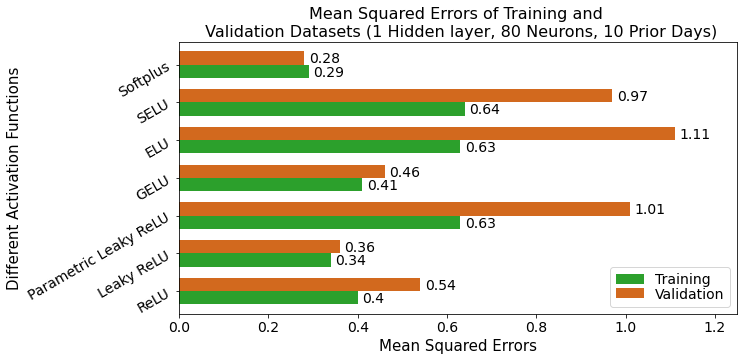

In [17]:
# Bar plot here 

# Defining the names of rows for pandas DataFrame
indices = ['ReLU', 'Leaky ReLU', 'Parametric Leaky ReLU', 'GELU', 'ELU', 'SELU', 'Softplus']

# Creating a pandas DataFrame with MSE Scores of all Models
trainingMSEs = [round(trainMSE10801relu,2), 
                round(trainMSE10801leakyrelu,2),  
                round(trainMSE10801paraleakyrelu,2),
                round(trainMSE10801gelu,2),
                round(trainMSE10801elu,2), 
                round(trainMSE10801selu,2), 
                round(trainMSE10801softplus,2)]
valMSEs = [round(valMSE10801relu,2),
           round(valMSE10801leakyrelu,2),
           round(valMSE10801paraleakyrelu,2),
           round(valMSE10801gelu,2),
           round(valMSE10801elu,2),
           round(valMSE10801selu,2),
           round(valMSE10801softplus,2)]
dfMSE = pd.DataFrame({'Training': trainingMSEs, 
                      'Validation': valMSEs}, 
                     index = indices) 

# Plotting the bar-plots
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1)
dfMSE.plot(ax = ax, 
           kind = 'barh', 
           width = 0.7,
           color={"Training": "tab:green", 
                  "Validation": "chocolate"},
           rot = 30)
ax.set_ylabel('Different Activation Functions', fontsize=15)
ax.set_xlabel('Mean Squared Errors', fontsize=15)
ax.set_xlim(0.0, 1.25)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title("Mean Squared Errors of Training and \n Validation Datasets (1 Hidden layer, 80 Neurons, 10 Prior Days)", fontsize=16) 
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='lower right')

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.01, i.get_y()+.05, \
            str(round(i.get_width(), 2)), 
            fontsize=14)

plt.show()

<a id='AnswerQB'></a>
<div class=" alert alert-info">
    <b>Answer.</b>

$\textbf{Observation}$: In my case, the model containing $\texttt{1}$ hidden layer with $\texttt{80}$ hidden neurons with $\texttt{softplus}$ as the activation function for $\texttt{10}$ prior days is the best model because the MSE score for the validation dataset ($\textsf{0.28}$) is the lowest for this model. 
    
</div>

<a id='QuestionC'></a>
<div class=" alert alert-warning">
    <b>Question.</b>
 
Plot the training and validation accuracy vs. training iteration (epochs) for the model. Also, plot your predicted adjusted closing prices from $10/1/16$ to now and the actual prices with respect to time, and report the MSE.

</div>

<a id='AnswerQC'></a>
<div class=" alert alert-info">
    <b>Answer.</b>

The MSE for the test dataset, evaluated on the model containing $\texttt{1}$ hidden layer with $\texttt{80}$ hidden neurons with $\texttt{softplus}$ as the activation function, is ($\textsf{66.17}$). 
    
The following two figures show the MSE scores for training and validation datasets with respect to the number of epochs (training iterations) and the real and predicted adjusted closing prices with respect to time for the ANN model with $\texttt{softplus}$ activation function in the hidden layer.
    
</div>

### Best Model (ANN Model with Lowest Validation Dataset MSE)

--- MSE Score for the Best ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (10 Prior Days) ---


Test Score: 66.17 MSE


----------------------------------------------------------------------------------------------------------


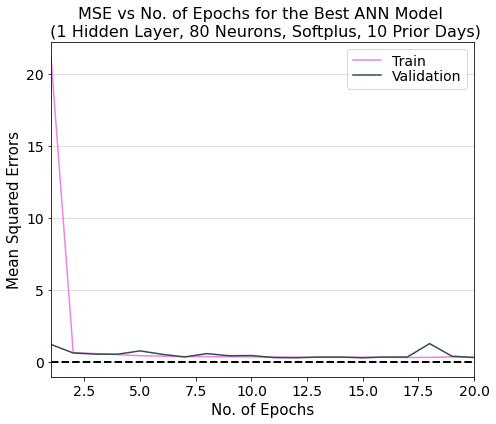

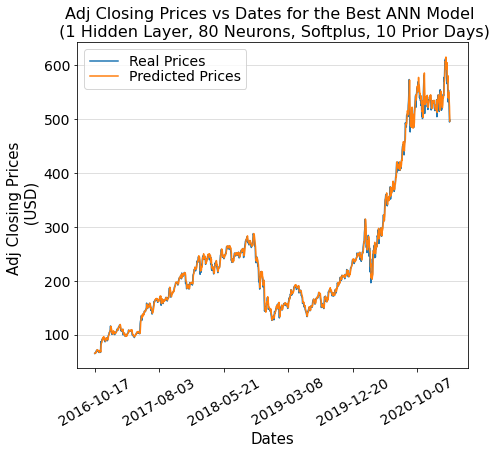

In [18]:
# Best ANN model
bestANNModel = model10801softplus

# Estimating the prediction for test dataset with best ANN model
yTestPred10801 = bestANNModel.predict(X_test)

# Calculating the MSE of the test dataset
testMSE10801 = get_mse(model=bestANNModel, realFeatures=X_test, realLabels=y_test)

# Printing the MSE
print('--- MSE Score for the Best ANN Model containing 1 Hidden Layer with 80 Hidden Neurons (10 Prior Days) ---')
print('\n')
print('Test Score: %.2f MSE' % (testMSE10801))
print('\n')
print('----------------------------------------------------------------------------------------------------------')

# Plotting training and validation MSE values v/s epochs for the Best ANN Model
titleString = "MSE vs No. of Epochs for the Best ANN Model \n (1 Hidden Layer, 80 Neurons, Softplus, 10 Prior Days)"
trainMSE = np.asarray(history10801softplus.history['loss']).reshape(-1,1) 
valMSE = np.asarray(history10801softplus.history['val_loss']).reshape(-1,1)
horzLine = np.linspace(1, 20)
horzLineData = np.array([0.00 for i in range(len(horzLine))])
fig, ax = plt.subplots(figsize=(7,6)) 
ax.plot(horzLine, horzLineData, 'k--', LineWidth=2)
ax.plot(range(1, 21), trainMSE, color='violet', label='Train')   
ax.plot(range(1, 21), valMSE, color='darkslategray', label='Validation')   
ax.set_title(titleString, fontsize=16)  
ax.set_ylabel('Mean Squared Errors', fontsize=15)   
ax.set_xlabel('No. of Epochs', fontsize=15)  
ax.set_xlim(left=1, right=20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid(axis='y', linestyle='-', alpha=0.5)
plt.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper right')   
plt.tight_layout()
plt.show()

# Plotting the Real and Predicted Adjusted Closing Prices for the Best ANN Model
testDates = tempTestDates.iloc[prior_days:]
dFrame = pd.DataFrame({'Date': testDates, 
                       'Real Prices': np.asarray(y_test).astype(np.float64).flatten(), 
                       'Predicted Prices': yTestPred10801.flatten()})
titleString = "Adj Closing Prices vs Dates for the Best ANN Model \n (1 Hidden Layer, 80 Neurons, Softplus, 10 Prior Days)"
fig, ax = plt.subplots(figsize=(7,6)) 
dFrame.plot(ax = ax, 
            x = "Date", 
            y = ["Real Prices", "Predicted Prices"],
            rot = 30)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_title(titleString, fontsize=16) 
ax.set_xlabel('Dates', fontsize=15)
ax.set_ylabel('Adj Closing Prices \n (USD)', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.5)
ax.legend(prop={'size': 14}, ncol=1, labelspacing=0.05, loc='upper left')
plt.show() 